In [1]:
import numpy as np
import torch
import os
from torch import tensor
import matplotlib.pyplot as plt
import pandas as pd
import IPython
from tqdm import tqdm

In [2]:
! pip install soundfile torchaudio umap-learn


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import soundfile as sf
import torchaudio
import umap

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/V

## Dataset

https://www.kaggle.com/datasets/luisblanche/birdcall-singing-3


In [4]:
sf.info("data/train/norcar/XC109034.wav")

data/train/norcar/XC109034.wav
samplerate: 32000 Hz
channels: 1
duration: 24.800 s
format: WAV (Microsoft) [WAV]
subtype: Signed 16 bit PCM [PCM_16]

In [5]:
sf.info("data/train/norpar/XC131884.wav")

data/train/norpar/XC131884.wav
samplerate: 32000 Hz
channels: 1
duration: 7.680 s
format: WAV (Microsoft) [WAV]
subtype: Signed 16 bit PCM [PCM_16]

In [6]:
from typing import List, Tuple


SAMPLE_RATE = 32000
MAX_DURATION_IN_SEC = 6
MAX_DURATION_IN_SAMPLES = MAX_DURATION_IN_SEC * SAMPLE_RATE

def get_dataset(dataset_name: str, model: torch.nn.Module, raw=False) -> List[Tuple[torch.Tensor, int]]:
    rng = np.random.default_rng(seed=1337)
    XY = []
    entries = []
    
    # get entries
    for entry in os.scandir(os.path.join("data", dataset_name)):
        if entry.is_dir():
            entries.append(entry)
    entries.sort(key=lambda e: e.name)
    
    # create tensors
    for n, entry in enumerate(entries):
        for wav in tqdm(os.scandir(entry)):
            if wav.is_file() and wav.name.endswith(".wav"):
                sample, sample_rate = torchaudio.load(wav.path, normalize=True)
                duration = sample.shape[1]
                
                if duration > MAX_DURATION_IN_SAMPLES:
                    begin = rng.integers(0, duration - MAX_DURATION_IN_SAMPLES)
                    sample = sample[:, begin: begin + MAX_DURATION_IN_SAMPLES]
                
                assert SAMPLE_RATE == sample_rate
                
                X = sample if raw else model.wav2lfcc(sample).float().requires_grad_(True)
                Y = n
                XY.append((X, Y))
    return XY

### Model overview

In [7]:
import model

In [8]:
import importlib
importlib.reload(model);

In [9]:
m = model.AudioFeatureExtractor(sample_rate=SAMPLE_RATE, n_lfcc=48, n_filter=256, hidden_size=24, n_fft=1024, win_length=None, hop_length=512, f_min=80, f_max=12000)

In [10]:
def draw_spectrogram(x, title, audio_path=None):
    plt.figure(figsize=(15, 4))
    plt.xlabel("Window index")
    plt.ylabel("Bin index")
    plt.title(title)
    plt.imshow(x.permute(1, 0), origin="lower", aspect="auto")
    plt.colorbar()
    plt.show()
    if audio_path:
        return IPython.display.Audio(audio_path)

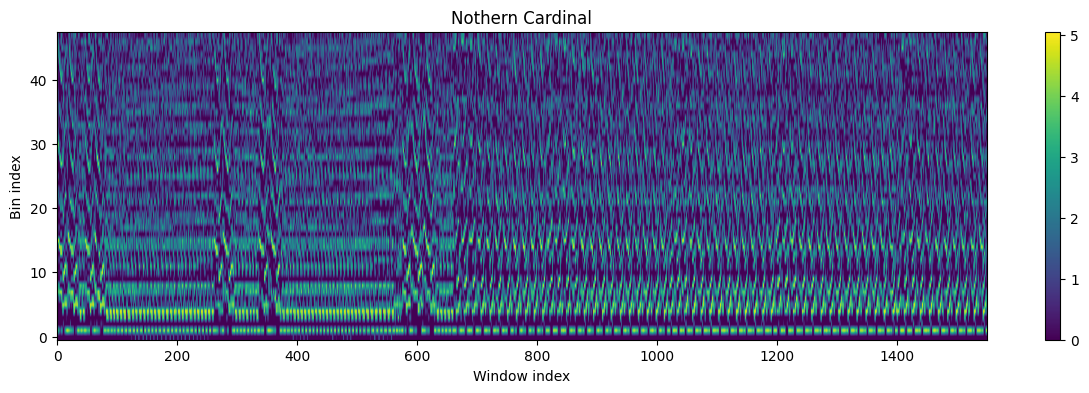

In [11]:
s, sr = torchaudio.load("data/train/norcar/XC109034.wav", normalize=True)
draw_spectrogram(m.wav2lfcc(s), "Nothern Cardinal", "data/train/norcar/XC109034.wav")

### Training

In [12]:
print("train dataset")
TRAIN_XY = get_dataset("train", m)

print("validation dataset")
VAL_XY = get_dataset("validation", m)

rng = np.random.default_rng(seed=1337)
rng.shuffle(TRAIN_XY)

TEST_XY = TRAIN_XY[:int(len(TRAIN_XY) / 100 * 20)]
TRAIN_XY = TRAIN_XY[len(TEST_XY):]

len(TRAIN_XY), len(TEST_XY), len(VAL_XY)

train dataset


100it [00:00, 133.05it/s]
100it [00:00, 164.22it/s]
100it [00:01, 89.28it/s]
100it [00:00, 124.88it/s]
100it [00:00, 141.32it/s]


validation dataset


29it [00:00, 155.24it/s]
39it [00:00, 171.56it/s]
30it [00:00, 236.55it/s]


(400, 100, 98)

In [13]:
# пример эмбединга
m.lfcc2emb(TRAIN_XY[0][0]).detach()

tensor([-0.0803, -0.1897, -0.0373,  0.0279,  0.3558, -0.5448, -0.6676,  0.2937])

In [14]:
num_epoches = 30
learning_rate = 1e-3
criterion = torch.nn.TripletMarginLoss()
optimizer = torch.optim.Adam(params=m.parameters(), lr=learning_rate)
losses = []

In [15]:
for epoch in range(num_epoches):
    rng.shuffle(TRAIN_XY)
    ref_embeddings = {}
    
    # референсные эмбединги.
    # эмбедилка будет учиться делать эмбединги одного класса как можно ближе к референсному эмбедингу
    # того же класса, и дальше от эмбедингов других классов.
    m.eval()
    for input_, target_ in TRAIN_XY:
        class_ = target_
        if class_ not in ref_embeddings:
            ref_embeddings[class_] = m.lfcc2emb(input_).detach()
    
    print("Iteration", epoch + 1)
    
    m.train()
    for input_, target_ in tqdm(TRAIN_XY):
        ref_embedding = ref_embeddings[target_]
        for class_, embedding in ref_embeddings.items():
            if target_ != class_:
                optimizer.zero_grad()
            
                output = m.lfcc2emb(input_)
                # be closer to embedding of target_ class, be further away from embeddings of other classes
                loss = criterion(output, ref_embedding, embedding)
                losses.append(loss.item())
            
                loss.backward()
                optimizer.step()
    
    m.eval()
    test_losses = []
    
    with torch.no_grad():
        for input_, target_ in TEST_XY:
            output = m.lfcc2emb(input_)
            loss = ((output - ref_embeddings[target_])**2).sum(axis=0)
            test_losses.append(loss.item())
    print("Test metrics: min {:.6f}, avg {:.6f}, max {:.6f}".format(\
        np.min(test_losses), np.average(test_losses), np.max(test_losses)))

Iteration 1


100%|██████████| 400/400 [00:51<00:00,  7.83it/s]


Test metrics: min 0.179119, avg 0.829866, max 1.595063
Iteration 2


100%|██████████| 400/400 [00:50<00:00,  7.88it/s]


Test metrics: min 0.103059, avg 0.484572, max 1.662955
Iteration 3


100%|██████████| 400/400 [00:50<00:00,  7.91it/s]


Test metrics: min 0.058148, avg 1.203930, max 3.326307
Iteration 4


100%|██████████| 400/400 [00:50<00:00,  7.91it/s]


Test metrics: min 0.095953, avg 0.900520, max 3.554263
Iteration 5


100%|██████████| 400/400 [00:50<00:00,  7.92it/s]


Test metrics: min 0.169968, avg 0.570194, max 1.611374
Iteration 6


100%|██████████| 400/400 [00:50<00:00,  7.92it/s]


Test metrics: min 0.003758, avg 0.080303, max 0.662386
Iteration 7


100%|██████████| 400/400 [00:50<00:00,  7.93it/s]


Test metrics: min 0.055093, avg 0.360219, max 1.469592
Iteration 8


100%|██████████| 400/400 [02:01<00:00,  3.28it/s] 


Test metrics: min 0.028944, avg 0.862391, max 2.758726
Iteration 9


100%|██████████| 400/400 [00:51<00:00,  7.82it/s]


Test metrics: min 0.035697, avg 0.954875, max 3.192487
Iteration 10


100%|██████████| 400/400 [00:49<00:00,  8.01it/s]


Test metrics: min 0.255897, avg 1.070197, max 2.446954
Iteration 11


100%|██████████| 400/400 [00:49<00:00,  8.05it/s]


Test metrics: min 0.004226, avg 0.361021, max 1.859212
Iteration 12


100%|██████████| 400/400 [00:48<00:00,  8.18it/s]


Test metrics: min 0.073821, avg 1.155489, max 3.428361
Iteration 13


100%|██████████| 400/400 [00:50<00:00,  7.98it/s]


Test metrics: min 0.054582, avg 0.963977, max 3.334166
Iteration 14


100%|██████████| 400/400 [00:50<00:00,  7.85it/s]


Test metrics: min 0.023221, avg 0.941788, max 3.773008
Iteration 15


100%|██████████| 400/400 [00:52<00:00,  7.66it/s]


Test metrics: min 0.013636, avg 0.884397, max 3.839563
Iteration 16


100%|██████████| 400/400 [00:53<00:00,  7.51it/s]


Test metrics: min 0.013993, avg 0.867565, max 3.821914
Iteration 17


100%|██████████| 400/400 [00:55<00:00,  7.27it/s]


Test metrics: min 0.024888, avg 1.125626, max 3.924065
Iteration 18


100%|██████████| 400/400 [00:54<00:00,  7.32it/s]


Test metrics: min 0.120378, avg 1.845526, max 3.925009
Iteration 19


100%|██████████| 400/400 [00:54<00:00,  7.37it/s]


Test metrics: min 0.058103, avg 1.111121, max 3.714344
Iteration 20


100%|██████████| 400/400 [00:54<00:00,  7.40it/s]


Test metrics: min 0.008649, avg 1.026527, max 3.863294
Iteration 21


100%|██████████| 400/400 [00:52<00:00,  7.68it/s]


Test metrics: min 0.023259, avg 1.594752, max 3.613719
Iteration 22


100%|██████████| 400/400 [00:50<00:00,  7.91it/s]


Test metrics: min 0.049812, avg 1.281856, max 3.546455
Iteration 23


100%|██████████| 400/400 [00:55<00:00,  7.20it/s]


Test metrics: min 0.244192, avg 1.938440, max 3.460487
Iteration 24


100%|██████████| 400/400 [00:52<00:00,  7.66it/s]


Test metrics: min 0.004064, avg 0.531369, max 1.953826
Iteration 25


100%|██████████| 400/400 [00:50<00:00,  7.92it/s]


Test metrics: min 0.026420, avg 0.716622, max 3.278684
Iteration 26


100%|██████████| 400/400 [00:53<00:00,  7.51it/s]


Test metrics: min 0.001727, avg 0.868690, max 3.730492
Iteration 27


100%|██████████| 400/400 [00:51<00:00,  7.79it/s]


Test metrics: min 0.008849, avg 0.870752, max 3.695760
Iteration 28


100%|██████████| 400/400 [00:53<00:00,  7.54it/s]


Test metrics: min 0.016293, avg 1.120768, max 3.847357
Iteration 29


100%|██████████| 400/400 [00:51<00:00,  7.83it/s]


Test metrics: min 0.009694, avg 0.845205, max 3.566682
Iteration 30


100%|██████████| 400/400 [00:51<00:00,  7.77it/s]


Test metrics: min 0.013620, avg 1.216561, max 3.698070


In [98]:
#torch.save(m.state_dict(), "model_dict.dat")

### Analysis

In [18]:
for class_ in sorted(list(ref_embeddings.keys())):
    print("Class", class_)
    print(ref_embeddings[class_])

Class 0
tensor([-0.1809,  0.3989, -0.4091,  0.1903,  0.5864,  0.2959,  0.1936,  0.3683])
Class 1
tensor([ 0.2537, -0.4411,  0.1668,  0.1886, -0.2763, -0.4909,  0.1509, -0.5810])
Class 2
tensor([-0.3322,  0.3536, -0.3358, -0.0143,  0.6218,  0.3505, -0.0029,  0.3769])
Class 3
tensor([ 0.2521, -0.5028,  0.1684,  0.0815, -0.2714, -0.4960,  0.1528, -0.5529])
Class 4
tensor([-0.1552,  0.5281, -0.3778,  0.3394,  0.3343,  0.3690,  0.1369,  0.4153])


In [19]:
def euclidian_dist(a, b):
    return ((a - b)**2).sum(axis=0)

In [20]:
def float_trunc(a, points=3):
    c = int(10**points)
    return int(a * c) / c

In [21]:
# матрица расстояний между эмбедингами
[[float_trunc(euclidian_dist(i, j).item()) for i in ref_embeddings.values()] for j in ref_embeddings.values()]

[[0.0, 0.016, 3.559, 3.646, 3.741],
 [0.016, 0.0, 3.492, 3.53, 3.724],
 [3.559, 3.492, 0.0, 0.114, 0.115],
 [3.646, 3.53, 0.114, 0.0, 0.292],
 [3.741, 3.724, 0.115, 0.292, 0.0]]

In [22]:
# матрица расстояний между эмбедингами (косинусное расстояние)
cos = torch.nn.CosineSimilarity(dim=0)
[[float_trunc(cos(i, j).item()) for i in ref_embeddings.values()] for j in ref_embeddings.values()]

[[1.0, 0.991, -0.779, -0.823, -0.87],
 [0.991, 1.0, -0.746, -0.765, -0.862],
 [-0.779, -0.746, 1.0, 0.942, 0.942],
 [-0.823, -0.765, 0.942, 1.0, 0.853],
 [-0.87, -0.862, 0.942, 0.853, 1.0]]

In [23]:
def plot_loss(losses, window):
    rolling_mean = pd.Series(losses).rolling(window=window).mean()
    plt.figure(figsize=(15, 5))
    plt.title("Loss function\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    plt.legend()
    plt.grid(True)

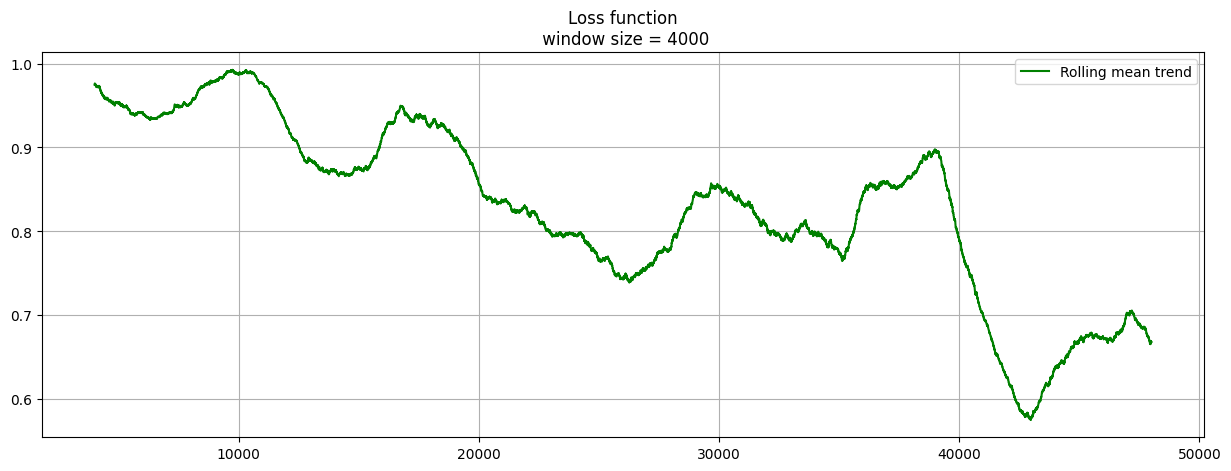

In [24]:
plot_loss(losses, window=4000)

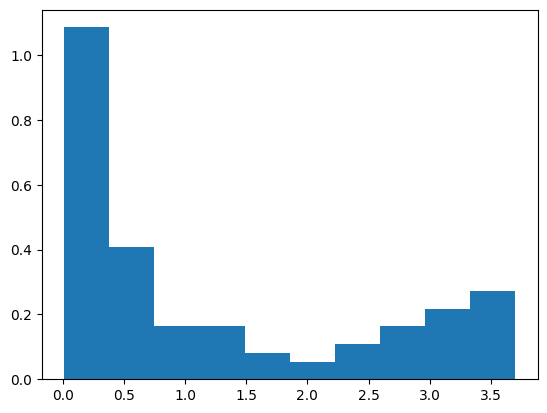

In [30]:
# лосс на тестовой выборке
plt.hist(test_losses, density=True);

### Evaluation

Important: we're gonna use totally different dataset

In [31]:
VAL_EMB_XY = [(m.lfcc2emb(x).detach().numpy(), y) for x, y in VAL_XY]
VAL_MEAN_XY = [(torch.mean(x, dim=0).detach().numpy(), y) for x, y in VAL_XY]

#### 1. Visualization - UMAP

Original labels

In [32]:
def umap_visualization(dataset):
    birds = []
    colors = []
    m.eval()

    for input_, target_ in dataset:
        birds.append(input_)
        colors.append(target_)
    
    u = umap.UMAP(n_neighbors=8, metric="euclidean", min_dist=0.01, spread=1.0)
    
    res = u.fit_transform(birds)
    
    plt.figure(figsize=(10, 5))
    plt.scatter(res[:,0], res[:,1], c=colors)

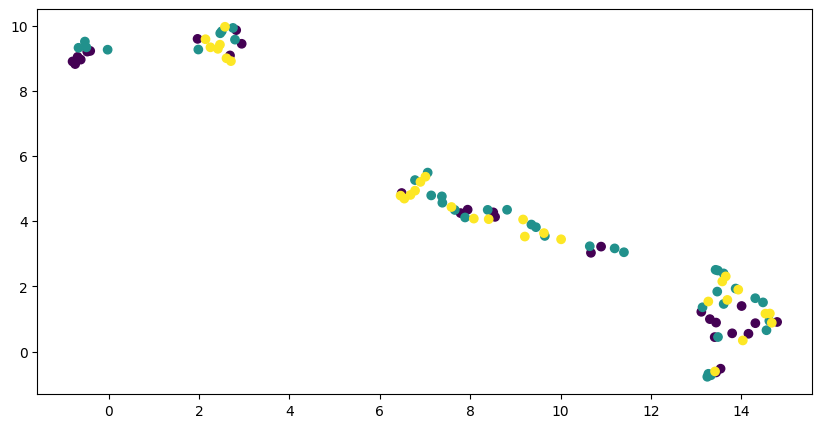

In [33]:
umap_visualization(VAL_EMB_XY)

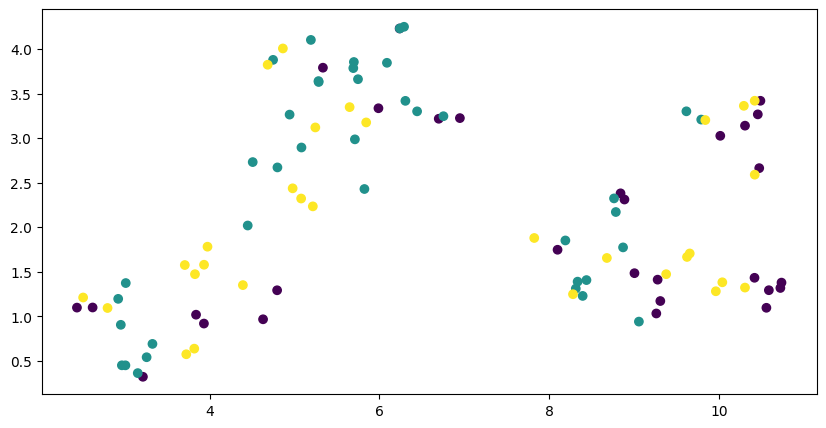

In [37]:
umap_visualization(VAL_MEAN_XY)

#### 2. Clusterization - DBSCAN (before UMAP)

In [38]:
from sklearn.cluster import DBSCAN

def dbscan_visualization(dataset, jaccard=False, **kwargs):
    birds = []
    m.eval()

    for input_, _ in dataset:
        birds.append(input_)
    
    dbs = DBSCAN(**kwargs)
    dbs.fit(birds)
    colors = dbs.labels_
    
    if jaccard:
        u = umap.UMAP(n_neighbors=10, metric="jaccard", min_dist=0.0001, spread=0.5)
    else:
        u = umap.UMAP(n_neighbors=8, metric="euclidean", min_dist=0.01, spread=1.0)
    
    res = u.fit_transform(birds)
    
    plt.figure(figsize=(10, 5))
    plt.scatter(res[:,0], res[:,1], c=colors)

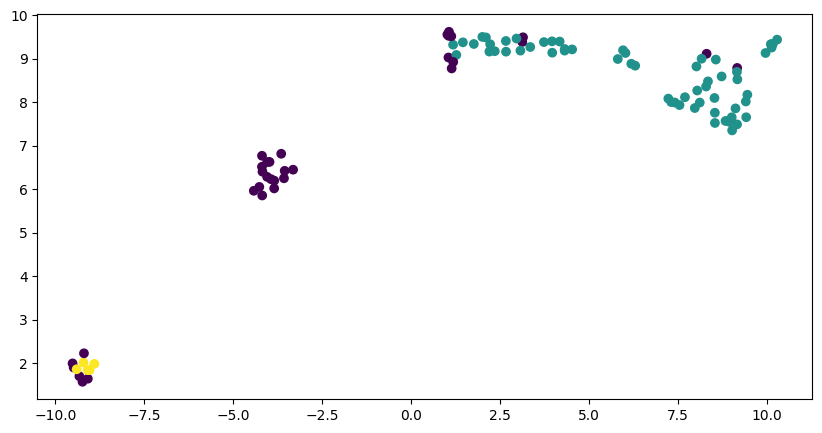

In [44]:
dbscan_visualization(VAL_EMB_XY, eps=0.2)

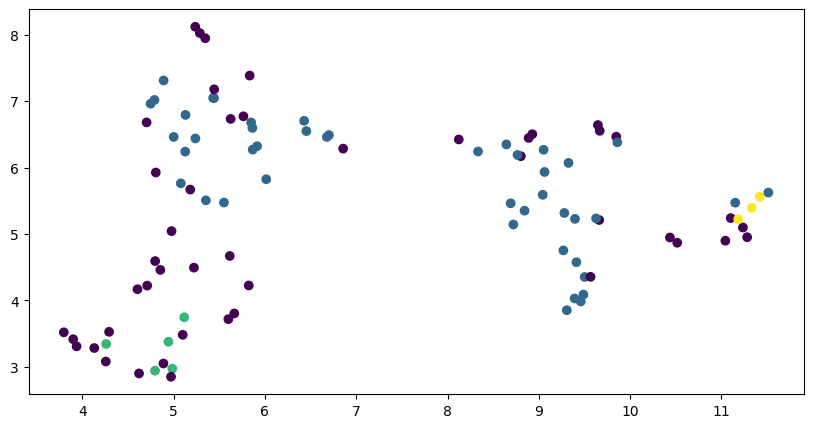

In [74]:
dbscan_visualization(VAL_MEAN_XY, eps=1.7)

### 3.1 Nearest embeddings, same species

In [75]:
VAL_RAW_XY = get_dataset("validation", m, raw=True)

29it [00:00, 235.17it/s]
39it [00:00, 304.05it/s]
30it [00:00, 535.77it/s]


In [91]:
a, b = None, None
min_dist = 1e9

for n, (i, s1) in enumerate(VAL_EMB_XY):
    for k, (j, s2) in enumerate(VAL_EMB_XY):
        if n != k and s1 == s2:
            dist = euclidian_dist(i, j).item()
            if min_dist > dist:
                min_dist = dist
                a, b = n, k

In [87]:
min_dist

0.001683429698459804

In [88]:
print("Species:", VAL_RAW_XY[a][1])
IPython.display.Audio(VAL_RAW_XY[a][0], rate=SAMPLE_RATE)

Species: 1


In [89]:
print("Species:", VAL_RAW_XY[b][1])
IPython.display.Audio(VAL_RAW_XY[b][0], rate=SAMPLE_RATE)

Species: 1


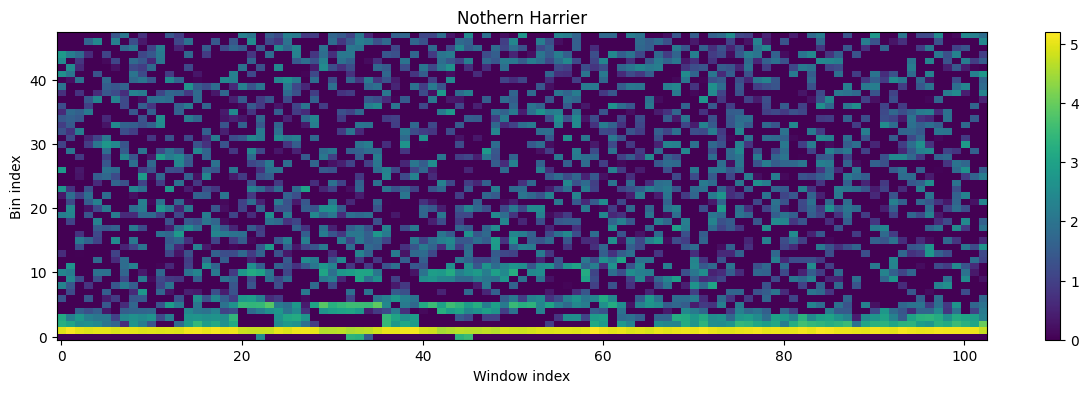

In [92]:
draw_spectrogram(m.wav2lfcc(VAL_RAW_XY[a][0]), "Nothern Harrier")

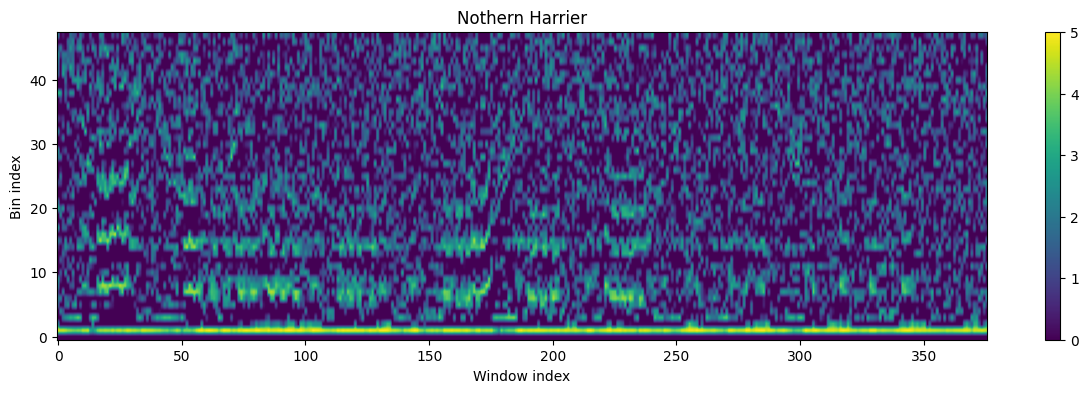

In [94]:
draw_spectrogram(m.wav2lfcc(VAL_RAW_XY[b][0]), "Nothern Harrier")

OK

#### 3.2 Nearest embeddings, but different species

In [80]:
a, b = None, None
min_dist = 1e9

for n, (i, s1) in enumerate(VAL_EMB_XY):
    for k, (j, s2) in enumerate(VAL_EMB_XY):
        if n != k and s1 != s2:
            dist = euclidian_dist(i, j).item()
            if min_dist > dist:
                min_dist = dist
                a, b = n, k

In [81]:
min_dist

0.0019268713658675551

In [82]:
print("Species:", VAL_RAW_XY[a][1])
IPython.display.Audio(VAL_RAW_XY[a][0], rate=SAMPLE_RATE)

Species: 1


In [83]:
print("Species:", VAL_RAW_XY[b][1])
IPython.display.Audio(VAL_RAW_XY[b][0], rate=SAMPLE_RATE)

Species: 2


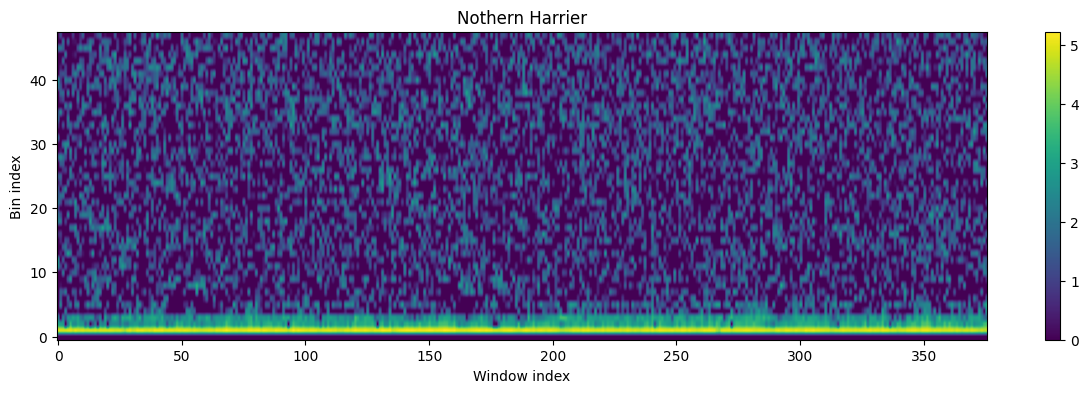

In [84]:
draw_spectrogram(m.wav2lfcc(VAL_RAW_XY[a][0]), "Nothern Harrier")

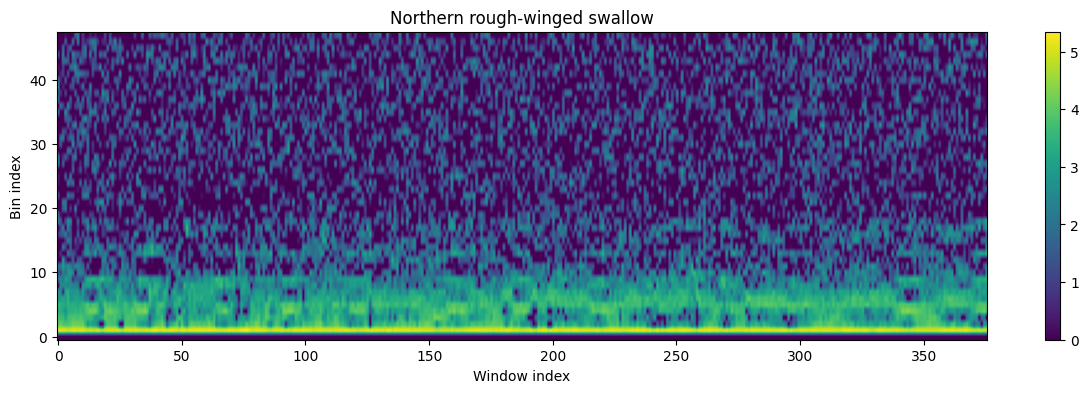

In [85]:
draw_spectrogram(m.wav2lfcc(VAL_RAW_XY[b][0]), "Northern rough-winged swallow")

#### Train and test dataset embeddings visualization

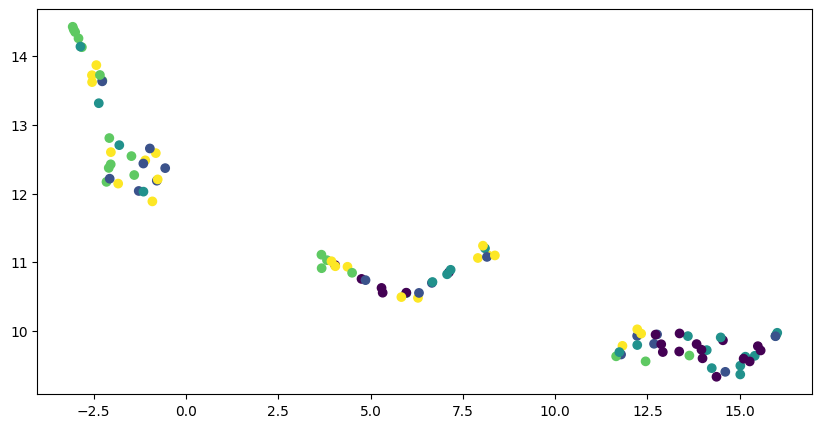

In [95]:
umap_visualization([(m.lfcc2emb(x).detach().numpy(), y) for x, y in TEST_XY])

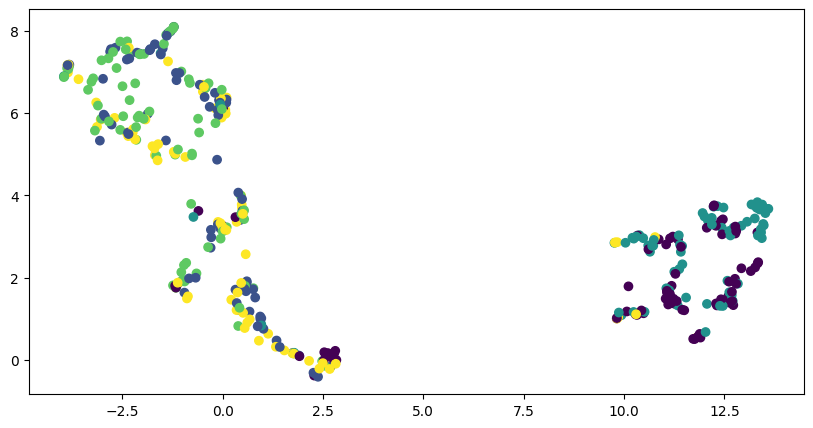

In [96]:
umap_visualization([(m.lfcc2emb(x).detach().numpy(), y) for x, y in TRAIN_XY])